In [1]:
import numpy as np
import torch

from model import one_hidden_layer
from dataset import create_dataset
from trainer import train_model

In [2]:
device = 'cpu'

In [3]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
f_SFRD         = './ML_lectures/data/SFRH_IllustrisTNG.npy'   #file with the SFRD data
f_params       = './ML_lectures/data/params_IllustrisTNG.txt' #file with the value of the parameters
min_valid_loss = 1e7                       #set this to a large number. Used to compute

batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 3e-4                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 300                       #number of epochs to train the network. Hyper-parameter

f_model = 'best_model.pt'

In [4]:
# get the data
train_loader = create_dataset('train', f_SFRD, f_params, batch_size, seed) #training data
valid_loader = create_dataset('valid', f_SFRD, f_params, batch_size, seed) #validation data

In [5]:
model = one_hidden_layer(100, 100, 12, dr) #architecture (we output 12 parameters, 6 posterior means, and 6 posterior standard deviations)
model.to(device=device)

one_hidden_layer(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=12, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (ReLU): ReLU()
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [6]:
model

one_hidden_layer(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=12, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (ReLU): ReLU()
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [28]:
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

model = train_model(
    epochs=epochs,
    model=model,
    f_model=f_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    device='cpu',
    optimizer=optim
)

000 -1.771e+00 -1.684e+00 (best-model)
001 -1.771e+00 -1.690e+00 (best-model)
002 -1.764e+00 -1.691e+00 (best-model)
003 -1.767e+00 -1.706e+00 (best-model)
004 -1.770e+00 -1.678e+00
005 -1.774e+00 -1.699e+00
006 -1.772e+00 -1.698e+00
007 -1.770e+00 -1.700e+00
008 -1.765e+00 -1.684e+00
009 -1.769e+00 -1.696e+00
010 -1.760e+00 -1.672e+00
011 -1.769e+00 -1.674e+00
012 -1.775e+00 -1.684e+00
013 -1.765e+00 -1.686e+00
014 -1.750e+00 -1.692e+00
015 -1.770e+00 -1.701e+00
016 -1.770e+00 -1.691e+00
017 -1.770e+00 -1.693e+00
018 -1.762e+00 -1.679e+00
019 -1.768e+00 -1.682e+00
020 -1.768e+00 -1.685e+00
021 -1.772e+00 -1.688e+00
022 -1.767e+00 -1.676e+00
023 -1.769e+00 -1.696e+00
024 -1.758e+00 -1.694e+00
025 -1.759e+00 -1.682e+00
026 -1.771e+00 -1.687e+00
027 -1.768e+00 -1.705e+00
028 -1.775e+00 -1.696e+00
029 -1.769e+00 -1.693e+00
030 -1.780e+00 -1.677e+00
031 -1.760e+00 -1.705e+00
032 -1.783e+00 -1.679e+00
033 -1.769e+00 -1.680e+00
034 -1.769e+00 -1.696e+00
035 -1.764e+00 -1.686e+00
036 -1.766e+

In [25]:
# get the test data
test_loader = create_dataset('test', f_SFRD, f_params, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

params_true = np.zeros((150,6), dtype=np.float32)
params_NN   = np.zeros((150,6), dtype=np.float32)
errors_NN   = np.zeros((150,6), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
count = 0
for SFRH_test, params_test, _ in test_loader:
    with torch.no_grad():

        bs = SFRH_test.shape[0]

        # move data to GPU
        SFRH_test   = SFRH_test.to(device)
        params_test = params_test.to(device)

        # make prediction using network
        p = model(SFRH_test)

        params_true[count:count+bs,:] = params_test.cpu().numpy()
        params_NN[count:count+bs, :]  = p[:,:6].cpu().numpy()
        errors_NN[count:count+bs, :]  = p[:,6:].cpu().numpy()

        loss1 = torch.mean((p[:,:6] - params_test)**2,                axis=0)
        loss2 = torch.mean(((p[:,:6] - params_test)**2 - p[:,6:])**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))

        # compute cumulative loss and number of examples used
        test_loss += loss.item()*bs
        points += SFRH_test.shape[0]

        count += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

test loss = -7.318e+00


/var/folders/gg/1kd93k4x47q5_gj92ljtjf000000gq/T/ipykernel_74953/2523764333.py:9: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(params_true[:,1]/((params_true[:, 0])**0.5), params_NN[:,1]/(params_NN[:,0]**0.5), yerr=np.absolute(errors_NN[:,1]/(params_NN[:,0]**0.5)),


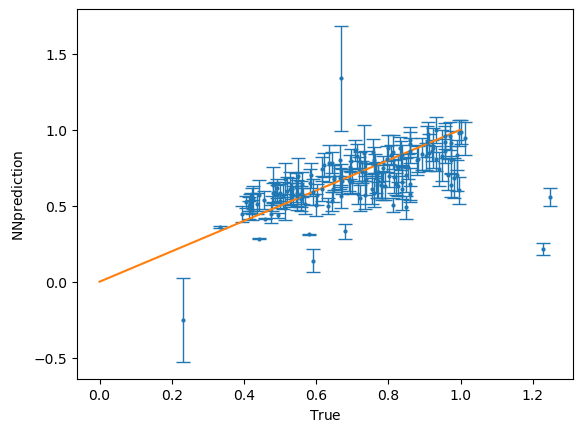

In [26]:
import matplotlib.pyplot as plt

plt.ylabel(r'${\rm NN prediction}$')
plt.xlabel(r'${\rm True}$')

#plt.xscale('log')
#plt.yscale('log')

plt.errorbar(params_true[:,1]/((params_true[:, 0])**0.5), params_NN[:,1]/(params_NN[:,0]**0.5), yerr=np.absolute(errors_NN[:,1]/(params_NN[:,0]**0.5)),
              lw=1, fmt='o',ms=2, elinewidth=1,capsize=5,linestyle='None')
#plt.scatter(params_true[:,0], params_NN[:,0])
plt.plot([0,1],[0,1])
#plt.plot(epochs2, valid_value)

plt.show()

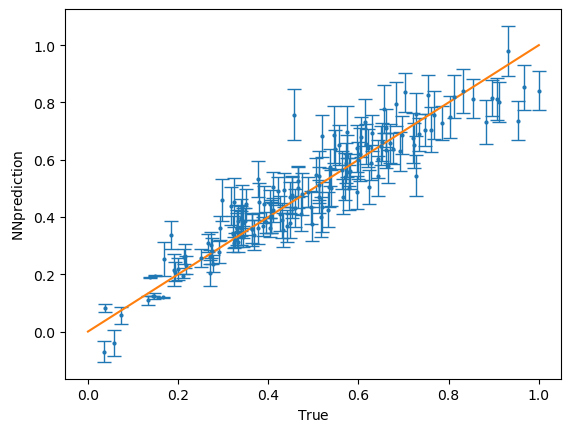

In [27]:
import matplotlib.pyplot as plt

plt.ylabel(r'${\rm NN prediction}$')
plt.xlabel(r'${\rm True}$')

#plt.xscale('log')
#plt.yscale('log')

plt.errorbar(params_true[:,1], params_NN[:,1], yerr=np.absolute(errors_NN[:,1]),
              lw=1, fmt='o',ms=2, elinewidth=1,capsize=5,linestyle='None')
#plt.scatter(params_true[:,0], params_NN[:,0])
plt.plot([0,1],[0,1])
#plt.plot(epochs2, valid_value)

plt.show()